# Investigating the saturation behavior of literature curated PPIs over time

The more well studied part of the protein by protein space might show a saturation of detecting PPIs, since most of them will be discovered. Here I look at number of PPIs over time whilst varying the number of publications per gene. I also look at the overlap between literature curated PPIs and HI-III, to see if interactions between the more well-studied proteins overlap between the two datasets more often.

In [1]:
import numpy as np
from scipy import stats
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
%matplotlib inline
from matplotlib_venn import venn2
import pandas as pd

from custom_settings import *
from utils import *

In [2]:
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 7.0
mpl.rcParams['savefig.dpi'] = 500

In [3]:
lit = load_nw_lit_bm_17()
hiu = load_nw_hi_union()
hi3 = load_nw_hi_iii()
n_pub = load_number_publications_per_gene()
for nw in [lit, hiu, hi3]:
    nw['pair'] = nw['ensembl_gene_id_a'] + '_' + nw['ensembl_gene_id_b']
    nw['n_pubs_a'] = nw['ensembl_gene_id_a'].map(n_pub).fillna(0)
    nw['n_pubs_b'] = nw['ensembl_gene_id_b'].map(n_pub).fillna(0)
    nw['n_pubs_min'] = nw[['n_pubs_a', 'n_pubs_b']].min(axis=1)

In [4]:
jcs = []
n_hi = []
n_pubs = list(range(0, 701))
errs = []
fs = []
rands = []
for n in n_pubs:
    a = set(hi3.loc[(hi3['n_pubs_min'] >= n), 'pair'].values)
    b = set(lit.loc[(lit['n_pubs_min'] >= n), 'pair'].values)
    n_hi.append((hi3['n_pubs_min'] >= n).sum())
    jc = len(a.intersection(b)) / len(a.union(b))
    jcs.append(jc)
    f = len(a.intersection(b)) / len(a)
    fs.append(f)
    # Using the standard error of proportion ignores the variability from
    # the number of literature pairs. Should be OK, since the number of HuRI
    # pairs at higher cutoffs is much smaller
    errs.append(np.sqrt((f * (1. - f)) / len(a)))
    rands.append(len(b) / ((n_pub > n).sum() * (n_pub > n).sum() / 2 + (n_pub > n).sum() / 2))

[52569, 19153, 4329, 989, 170]


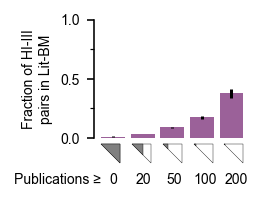

In [5]:
# Try turning this into bar charts
# Need to pick a cut point: either >= 200 pubs or top 1k most studied genes
def dense_zone_triangle(ax, f_dense, length=0.2, pos=(0, 0)):
    """
    
    Args:
        pos (tuple(float, float)): position of top left corner
    
    """
    triangle = Polygon([pos,
                        (pos[0] + length, pos[1]), 
                        (pos[0] + length, pos[1] - length)],
                       edgecolor='black',
                       facecolor='white',
                       linewidth=0.2,
                       clip_on=False)
    inner = Polygon([pos, 
                     (pos[0] + length * f_dense, pos[1]), 
                     (pos[0] + length * f_dense, pos[1] - length * f_dense)],
                    edgecolor='black',
                    linewidth=0.2,
                    facecolor='grey',
                    clip_on=False)
    ax.add_patch(triangle)
    ax.add_patch(inner)
    return triangle

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(1.4, 1.9)
split_points = [0, 20, 50, 100, 200]
f = [fs[n_pubs.index(split_point)] for split_point in split_points]
err = [errs[n_pubs.index(split_point)] for split_point in split_points]

n = [int(np.round((f_i * (1 - f_i)) / e_i**2)) for f_i, e_i in zip(f, err)]
print(n)

ax.set_aspect('equal', 'box')
ax.bar(np.linspace(0., 1, len(split_points)), f,
        color=HURI_COLOR,
       width=1. / len(split_points))
ax.errorbar(np.linspace(0., 1, len(split_points)),
             f,
             yerr=err,
             fmt='none',
             color='black')
ax.set_ylabel('Fraction of HI-III\npairs in Lit-BM')
ax.set_ylim((0., 1.))
ax.set_yticks([0., 0.5, 1.])
ax.set_yticks([0.25, 0.75], minor=True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
for i, split_point in enumerate(split_points):
    f_dense = (n_pub >= split_point).sum() / n_pub.shape[0]
    x = i * (1.3 / len(split_points)) - 0.1
    y = -0.05
    triangle = dense_zone_triangle(ax,
                                   f_dense,
                                   length=0.8 / len(split_points),
                                   pos=(x, y))
    draw_percent = False
    draw_n_pub = True
    if draw_percent:
        f_space = f_dense ** 2
        if f_space >= 0.01:
            txt = ax.text(x, -0.35, '{:.0%}'.format(f_space),
                          fontsize=5)
        else:
            txt = ax.text(x, -0.35, '{:.1%}'.format(f_space),
                          fontsize=5)
    elif draw_n_pub:
        ax.text(x + 0.1, -0.385, str(split_point), ha='center')
txt = ax.text(-0.1, -0.385, 'Publications ≥', ha='right')
for fmt in FORMATS:
    plt.savefig('../figures/lit_overlap_bar' + fmt,
                bbox_extra_artists=[triangle, txt],
                bbox_inches='tight')